# 2

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
import scipy.stats as stats
import arch
import warnings
warnings.filterwarnings("ignore")
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance
sns.set_theme()

In [47]:
risk_free_rate = pd.read_excel('../data/dfa_analysis_data.xlsx', sheet_name = 'factors')[['Date','RF']].set_index('Date')
factors = pd.read_excel('../data/dfa_analysis_data.xlsx', sheet_name = 'factors').drop(columns = ['RF']).set_index('Date')
portfolio_total_returns = pd.read_excel('../data/dfa_analysis_data.xlsx', sheet_name = 'portfolios (total returns)').set_index('Date')

In [48]:
display(risk_free_rate.head(3))
display(factors.head(3))
display(portfolio_total_returns.head(3))

,RF
Date,
1926-07-31,0.0022
1926-08-31,0.0025
1926-09-30,0.0023


,Mkt-RF,SMB,HML
Date,,,
1926-07-31,0.0296,-0.0256,-0.0243
1926-08-31,0.0264,-0.0117,0.0382
1926-09-30,0.0036,-0.0140,0.0013


,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.058248,-0.017006,0.004875,-0.014580,0.020534,0.012077,0.024192,0.004926,-0.026049,-0.003344,...,0.015893,0.015278,0.012978,0.002727,0.024678,0.034539,0.060902,0.020266,0.031111,0.005623
1926-08-31,-0.020206,-0.080282,0.013796,0.014606,0.083968,0.023618,-0.011849,0.040084,0.005038,0.061675,...,0.013336,0.038730,0.020021,0.021706,0.053422,0.010124,0.041903,0.020131,0.054849,0.077576
1926-09-30,-0.048291,-0.026154,-0.043417,-0.032729,0.008649,-0.026540,-0.012618,0.010829,-0.035480,-0.009401,...,0.010923,-0.005250,-0.017636,0.014646,0.008730,-0.012906,0.036538,0.000950,-0.007487,-0.024284


In [49]:
portfolio_excess_returns = portfolio_total_returns.sub(risk_free_rate.values)

## 2.1

In [50]:
def performance_summary(return_data):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*12)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(12))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [51]:
def time_series_regression(portfolio, factors, FF3F = False, resid = False):
    
    ff_report = pd.DataFrame(index=portfolio.columns)
    bm_residuals = pd.DataFrame(columns=portfolio.columns)

    rhs = sm.add_constant(factors)

    for portf in portfolio.columns:
        lhs = portfolio[portf]
        res = sm.OLS(lhs, rhs, missing='drop').fit()
        ff_report.loc[portf, 'alpha_hat'] = res.params['const'] * 12
        ff_report.loc[portf, 'beta_mkt'] = res.params[1]
        if FF3F:
            ff_report.loc[portf, 'Size beta'] = res.params[2] 
            ff_report.loc[portf, 'Value beta'] = res.params[3]
            
        ff_report.loc[portf, 'info_ratio'] = np.sqrt(12) * res.params['const'] / res.resid.std()
        ff_report.loc[portf, 'treynor_ratio'] = 12 * portfolio[portf].mean() / res.params[1]
        ff_report.loc[portf, 'R-squared'] = res.rsquared
        ff_report.loc[portf, 'Tracking Error'] = (res.resid.std()*np.sqrt(12))

        if resid:
            bm_residuals[portf] = res.resid
            
            
        
    if resid:
        return bm_residuals
        
    return ff_report

In [70]:
def tangency_weights(returns, cov_mat = 1):
    
    if cov_mat ==1:
        cov_inv = np.linalg.inv((returns.cov()*12))
    else:
        cov = returns.cov()
        covmat_diag = np.diag(np.diag((cov)))
        covmat = cov_mat * cov + (1-cov_mat) * covmat_diag
        cov_inv = np.linalg.inv((covmat*12))  
        
    ones = np.ones(returns.columns.shape) 
    mu = returns.mean()*12
    scaling = 1/(np.transpose(ones) @ cov_inv @ mu)
    tangent_return = scaling*(cov_inv @ mu) 
    tangency_wts = pd.DataFrame(index = returns.columns, data = tangent_return, columns = ['Tangent Weights'] )
        
    return tangency_wts

In [53]:
factor_summary = performance_summary(factors)
factor_summary

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery
Mkt-RF,0.082236,0.18471,0.445216,0.153609,7.438434,-0.079310,-0.120229,-0.2913,0.3885,-0.846853,1929-08-31,1932-06-30,1945-02-28
SMB,0.021225,0.11004,0.192886,1.815108,18.306166,-0.042205,-0.058622,-0.1720,0.3656,-0.548264,1983-07-31,1999-03-31,2021-02-28
HML,0.041237,0.12357,0.333713,2.055936,18.040259,-0.042100,-0.066795,-0.1388,0.3561,-0.584097,2006-12-31,2020-09-30,NaT


In [54]:
sub_1980 = factors.loc[:'1980']
sub_2001 = factors.loc['1981':'2001']
sub_2022 = factors.loc['2002':]

df_dict={'1926-1980' : sub_1980,
         '1981-2001' : sub_2001,
         '2002-2024' : sub_2022}

summary_lst = []
for key in df_dict.keys():
    summary_stats = performance_summary(df_dict[key]).loc[:, ['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]
    summary_stats['Period'] = key
    summary_stats= summary_stats.reset_index().rename(columns = {'index':'Factor'}).set_index(['Period','Factor'])
    summary_lst.append(summary_stats)


factor_summary = pd.concat(summary_lst)
factor_summary


Mean  Volatility  Sharpe Ratio  VaR (0.05)
Period    Factor                                                
1926-1980 Mkt-RF  0.081138    0.205050      0.395696   -0.083985
          SMB     0.033985    0.114568      0.296638   -0.043400
          HML     0.049479    0.133825      0.369727   -0.042910
1981-2001 Mkt-RF  0.077257    0.157396      0.490847   -0.064545
          SMB    -0.000862    0.118346     -0.007283   -0.046515
          HML     0.063776    0.111183      0.573612   -0.041790
2002-2024 Mkt-RF  0.089488    0.154644      0.578674   -0.078735
          SMB     0.011007    0.088944      0.123757   -0.039070
          HML     0.000538    0.107348      0.005014   -0.041245

## 2.2

(a)

The market factor provided a premium in every subsample. But, the size factor casued a negative excess return in the 1981-2001 subsample, and the value factor provide nearly 0 premium in the post-2002 subsample. 

(b)

Yes. It's quite clear that the premium of the size factor was much bigger in the first subsample compared to the later ones. 

(c)

No. The premium of the value factor was quite large in the 1981-2001 subsample. But after 2002, the effect declines significantly to 0.

(d)

If we judge by the Sharpe that these factors are providing, then the market factor continued to be a strong performer, the value factor is basically non-existant, and the impact of the size factor is quite small. 

## 2.3

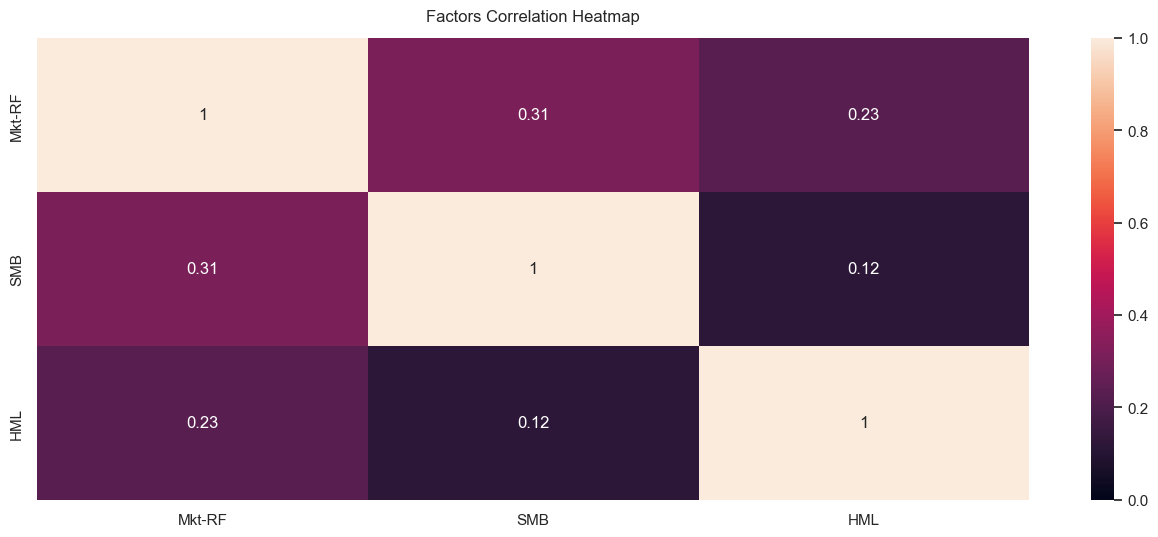

In [55]:
factor_corr = factors.corr()

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(factor_corr, vmin=0, vmax=1, annot=True)
heatmap.set_title('Factors Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

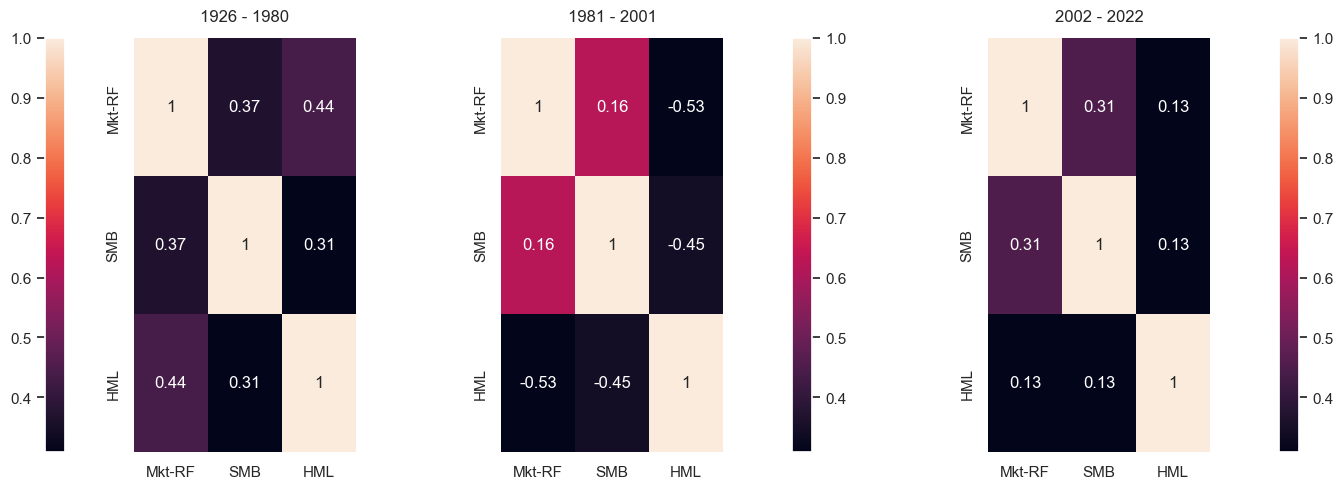

In [56]:
fig, (ax,ax2,ax3) = plt.subplots(ncols=3)

fig.subplots_adjust(wspace=0.01)
fig.tight_layout(pad=1)
sns.heatmap(sub_1980.corr(), ax=ax, cbar=False, annot = True).set_title('1926 - 1980', fontdict={'fontsize':12}, pad=12);

fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(sub_2001.corr(), ax=ax2, cbar=False, annot = True).set_title('1981 - 2001', fontdict={'fontsize':12}, pad=12);

fig.colorbar(ax.collections[0],ax=ax2,location="right", use_gridspec=False, pad=0.2)

sns.heatmap(sub_2022.corr(), ax=ax3, cbar=False, annot = True).set_title('2002 - 2022', fontdict={'fontsize':12}, pad=12);
fig.colorbar(ax.collections[0],ax=ax3,location="right", use_gridspec=False, pad=0.2)

fig.set_figwidth(15)
plt.show()

## 2.4

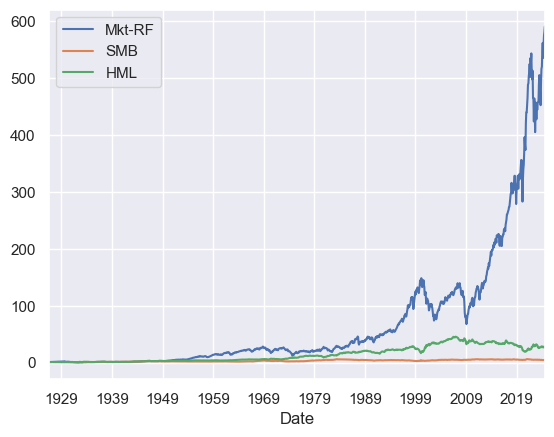

<Figure size 10000x600 with 0 Axes>

In [57]:
figure = ((factors + 1).cumprod()).plot()
plt.figure(figsize=(100, 6))
plt.show()

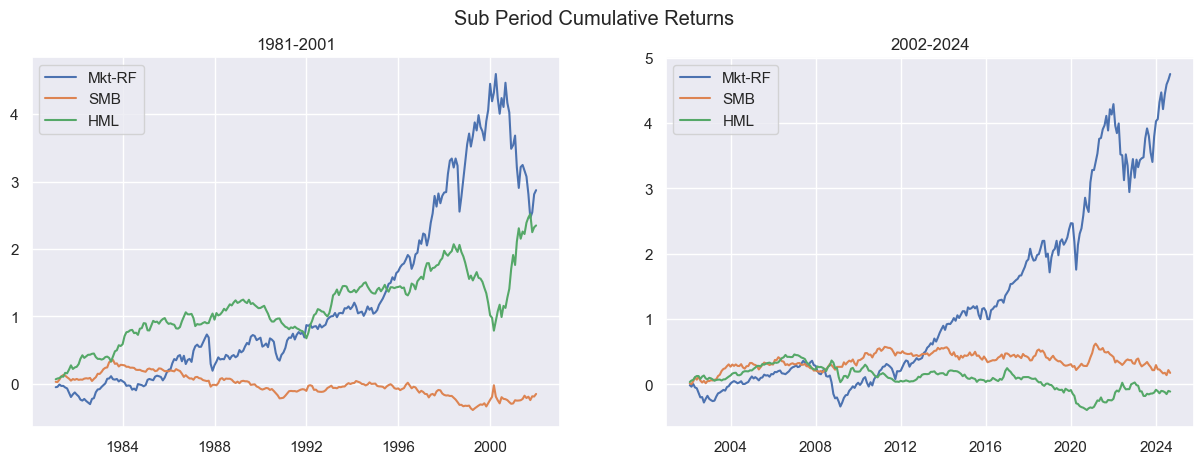

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Sub Period Cumulative Returns')
ax1.plot(((sub_2001 + 1).cumprod() - 1))
ax2.plot(((sub_2022 + 1).cumprod() - 1))

fig.set_figwidth(15)
ax1.legend(sub_2001.columns)
ax2.legend(sub_2022.columns)

ax1.title.set_text('1981-2001')
ax2.title.set_text('2002-2024')

# 3

## 3.1

In [59]:
port_summary = performance_summary(portfolio_excess_returns.loc['1981-01-01':])
port_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
SMALL LoBM,0.006671,0.273771,0.024366,-0.126059
ME1 BM2,0.088689,0.236403,0.375163,-0.094747
ME1 BM3,0.092006,0.201252,0.457170,-0.086227
ME1 BM4,0.115998,0.194270,0.597099,-0.076972
SMALL HiBM,0.127838,0.210037,0.608646,-0.088535
ME2 BM1,0.058868,0.245156,0.240125,-0.104096
ME2 BM2,0.100515,0.205528,0.489059,-0.085661
ME2 BM3,0.105946,0.185777,0.570288,-0.078490
ME2 BM4,0.108835,0.182098,0.597670,-0.076138
ME2 BM5,0.115994,0.215616,0.537967,-0.096398


Text(0, 0.5, 'Mean Excess Returns')

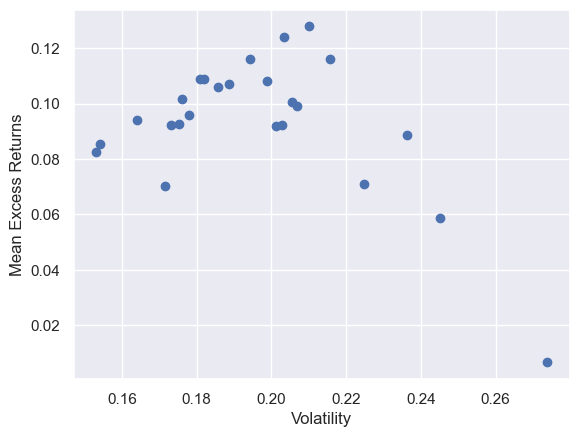

In [60]:
plt.scatter(port_summary.loc[:,['Volatility']],port_summary.loc[:,['Mean']])
plt.xlabel("Volatility")
plt.ylabel("Mean Excess Returns")

Text(0, 0.5, 'Mean Excess Returns')

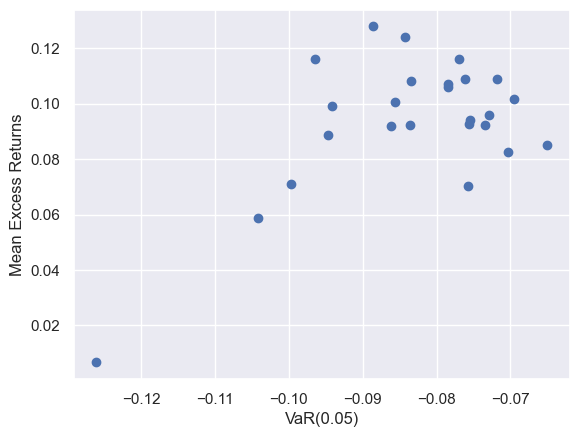

In [61]:
plt.scatter( port_summary.loc[:,['VaR (0.05)']],port_summary.loc[:,['Mean']])
plt.xlabel("VaR(0.05)")
plt.ylabel("Mean Excess Returns")

There is no clear trend in the scatterplot between vol versus mean, and VaR versus mean. I don't think the differences in the mean excess returns could be explained by these two factors. 

## 3.2

### (a)

In [62]:
ts_CAPM = time_series_regression(portfolio_excess_returns.loc['1981':], factors.loc['1981':,'Mkt-RF'])

### (b) (c)

In [63]:
ts_CAPM

,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
SMALL LoBM,-0.106730,1.356365,-0.613409,0.004918,0.596078,0.173994
ME1 BM2,-0.008774,1.165744,-0.057999,0.076080,0.590508,0.151278
ME1 BM3,0.004620,1.045218,0.039081,0.088026,0.655026,0.118204
ME1 BM4,0.034696,0.972450,0.285425,0.119285,0.608481,0.121558
SMALL HiBM,0.044652,0.994979,0.315148,0.128483,0.544955,0.141685
ME2 BM1,-0.053049,1.338627,-0.411917,0.043976,0.724033,0.128787
ME2 BM2,0.005631,1.134902,0.053775,0.088568,0.740451,0.104708
ME2 BM3,0.019949,1.028607,0.212415,0.103000,0.744454,0.093913
ME2 BM4,0.027344,0.974696,0.272232,0.111660,0.695744,0.100444
ME2 BM5,0.022822,1.114415,0.178588,0.104085,0.648719,0.127793


In [64]:
ts_CAPM['alpha_hat'].abs().mean()

np.float64(0.022428026900773754)

If CAPM were true, then this number should be very close to 0. 

### (d)
If CAPM were true, we would expect the Treynor ratios to all be the same. Since we're expecting the alphas to be close to zero, then we should expect the information ratios to be close to zero. 

## 3.3

### (a) (b) (C)

In [65]:
portfolio = portfolio_excess_returns.loc['1981':].mean().to_frame('Mean Portfolio excess returns')

In [66]:
result_table = time_series_regression(portfolio, ts_CAPM['beta_mkt'])
result_table['beta_mkt'] *= 12
result_table

,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
Mean Portfolio excess returns,0.208623,-0.108185,35.404667,-10.4114,0.300557,0.005893


If CAPM were true, R-squared would be very high, the intercept should be very close to 0, and the regression coefficient should be positive. 

## 3.4

Broadly speaking, these results do support DFA's belief in size and value portfolios containing premia unrelated to CAPM. We're seeing a low R-squared value, large intercept, and slightly negative regression coefficient, all of which goes against what we'd expect if CAPM were true. 

# 4

## 4.1

In [71]:
w_t = tangency_weights(portfolio_excess_returns['1981':].reset_index().drop('Date', axis = 1))
TangencyPort_df = pd.DataFrame(w_t,columns= ["Tangent Weights"],index=port_summary.index)
TangencyRets = (portfolio_excess_returns @ TangencyPort_df).rename(columns={'Tangency Portfolio Weight':'Tangency Returns'})
tangency_ts = time_series_regression(portfolio_excess_returns.loc['1981':], TangencyRets.loc['1981':],False)
tangency_ts

,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
SMALL LoBM,9.305707e-16,0.017416,3.399386e-15,0.383026,0.000174,0.273747
ME1 BM2,6.846737e-16,0.231549,2.957941e-15,0.383026,0.041297,0.231470
ME1 BM3,1.793487e-15,0.240209,9.198170e-15,0.383026,0.061325,0.194983
ME1 BM4,2.810252e-16,0.302847,1.528741e-15,0.383026,0.104610,0.183828
SMALL HiBM,3.664061e-16,0.333758,1.847797e-15,0.383026,0.108695,0.198293
ME2 BM1,6.138075e-16,0.153692,2.525198e-15,0.383026,0.016918,0.243073
ME2 BM2,1.272277e-15,0.262425,6.419632e-15,0.383026,0.070178,0.198185
ME2 BM3,7.793245e-16,0.276604,4.410670e-15,0.383026,0.095427,0.176691
ME2 BM4,7.193139e-16,0.284144,4.174985e-15,0.383026,0.104810,0.172291
ME2 BM5,1.245260e-15,0.302836,6.037398e-15,0.383026,0.084917,0.206258


In [72]:
portfolio = portfolio_excess_returns.loc['1981':].mean().to_frame('Mean Portfolio excess returns')

In [74]:
result_table_tangency = time_series_regression(portfolio, tangency_ts.loc[:,['beta_mkt']], False)
result_table_tangency['beta_mkt'] *= 12
result_table_tangency

,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
Mean Portfolio excess returns,7.680217e-16,0.383026,7.759655,2.940675,1.0,9.897627e-17


In this case, the alpha gets to 0 and R^2 gets to 1, meaning that this should be a good verification for the CAPM model.

## 4.2

In [75]:
ts_FF3F = time_series_regression(portfolio_excess_returns.loc['1981':], factors.loc['1981':],True)

In [76]:
ts_FF3F

,alpha_hat,beta_mkt,Size beta,Value beta,info_ratio,treynor_ratio,R-squared,Tracking Error
SMALL LoBM,-0.085811,1.111846,1.392517,-0.253788,-0.937530,0.006000,0.888226,0.091529
ME1 BM2,0.001435,0.965456,1.317675,-0.014432,0.020344,0.091863,0.910924,0.070556
ME1 BM3,0.000595,0.923142,1.065113,0.277445,0.011988,0.099666,0.939265,0.049597
ME1 BM4,0.022184,0.877818,1.065753,0.477399,0.467283,0.132144,0.940281,0.047474
SMALL HiBM,0.023053,0.929787,1.066006,0.691417,0.312014,0.137492,0.876254,0.073886
ME2 BM1,-0.032422,1.141897,1.023281,-0.310250,-0.539477,0.051553,0.939904,0.060099
ME2 BM2,0.007150,1.013778,0.915858,0.121287,0.141210,0.099149,0.939304,0.050635
ME2 BM3,0.008658,0.973977,0.719244,0.389224,0.165561,0.108777,0.920763,0.052295
ME2 BM4,0.008373,0.941288,0.748332,0.575080,0.186100,0.115623,0.938957,0.044991
ME2 BM5,-0.005771,1.089194,0.929779,0.832768,-0.124297,0.106495,0.953637,0.046426


In [77]:
portfolio = portfolio_excess_returns.loc['1981':].mean().to_frame('Mean Portfolio excess returns')

In [78]:
result_table_new = time_series_regression(portfolio, ts_FF3F.loc[:,['beta_mkt','Size beta','Value beta']], True)
result_table_new['beta_mkt'] *= 12
result_table_new

,alpha_hat,beta_mkt,Size beta,Value beta,info_ratio,treynor_ratio,R-squared,Tracking Error
Mean Portfolio excess returns,0.186491,-0.100186,-0.000156,0.002927,36.112277,-11.24266,0.462776,0.005164


## 4.3

### (a) (b)

In [80]:
resid = time_series_regression(portfolio_excess_returns.loc['1981':], factors.loc['1981':,'Mkt-RF'], False, True)

In [81]:
T = portfolio_excess_returns['1981':].shape[0]
SR = factors['1981':]['Mkt-RF'].mean() *12/ factors['1981':]['Mkt-RF'].std()*np.sqrt(12)
Sigma = resid.cov()
Sigma_inv = pd.DataFrame(np.linalg.inv(Sigma), index=Sigma.index, columns=Sigma.columns)
alpha = ts_CAPM['alpha_hat']

H = T * (1 + SR**2)**(-1) * (alpha @ Sigma_inv @ alpha)

print('H = {:.2f}'.format(H))
pvalue = 1 - stats.chi2.cdf(H, df=25)
print('p-value = {:.4f}'.format(pvalue))

H = 472.07
p-value = 0.0000


Joint test must be stricter. H is significant as the p-value is much lower than 0.05

This test is to check whether investing in the alphas gets beyond the tangency portfolio.